In [104]:
import numpy as np
import pandas as pd

# evaluate.py

In [54]:
import re
import string
from collections import Counter

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)


def evaluate(dataset, predictions):
    f1 = exact_match = total = 0
    for article in dataset:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                total += 1
                if qa['id'] not in predictions:
                    message = 'Unanswered question ' + qa['id'] + \
                              ' will receive score 0.'
                    print(message, file=sys.stderr)
                    continue
                ground_truths = list(map(lambda x: x['text'], qa['answers']))
                prediction = predictions[qa['id']]
                exact_match += metric_max_over_ground_truths(
                    exact_match_score, prediction, ground_truths)
                f1 += metric_max_over_ground_truths(
                    f1_score, prediction, ground_truths)

    exact_match = 100.0 * exact_match / total
    f1 = 100.0 * f1 / total

    return {'exact_match': exact_match, 'f1': f1}

# Load Data

In [1]:
import json

In [29]:
# Constants
DEV_DATA_JSON_FILE = 'data/tiny-dev.json'
PRED1_JSON_FILE = 'predictions.json'
PRED2_JSON_FILE = 'predictions.json'

In [40]:
with open(DEV_DATA_JSON_FILE, 'r') as fin:
    dev_data = json.load(fin)
    assert dev_data['version'] == '1.1'
    dataset = dev_data['data']

with open(PRED1_JSON_FILE, 'r') as fin:
    predictions1 = json.load(fin)
    
with open(PRED2_JSON_FILE, 'r') as fin:
    predictions2 = json.load(fin)

In [39]:
predictions1

{'56be4db0acb8001400a502ec': 'champion denver broncos',
 '56be4db0acb8001400a502ed': 'champion denver broncos',
 '56be4db0acb8001400a502ee': 'santa clara, california',
 '56be4db0acb8001400a502ef': 'champion denver broncos',
 '56be4db0acb8001400a502f0': 'golden anniversary "with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each super bowl game with roman numerals',
 '56be4e1facb8001400a502f6': 'cam newton',
 '56be4e1facb8001400a502f9': 'eight',
 '56be4e1facb8001400a502fa': '1995',
 '56be4eafacb8001400a50302': 'denver linebacker von miller',
 '56be4eafacb8001400a50303': 'two',
 '56be4eafacb8001400a50304': 'the broncos',
 '56be5333acb8001400a5030a': 'cbs',
 '56be5333acb8001400a5030b': '$5 million',
 '56be5333acb8001400a5030c': 'coldplay',
 '56be5333acb8001400a5030d': 'beyoncé and bruno mars',
 '56be5333acb8001400a5030e': 'xlviii',
 '56be53b8acb8001400a50314': 'roger goodell',
 '56be53b8acb8001400a50315': 'spectacular',
 '56be53b8acb8001400a503

In [26]:
print('len(dev_data["data"]): {}'.format(len(dev_data['data'])))
print('dev_data["data"].keys(): {}'.format(dev_data['data'][0].keys()))
print("len(dev_data['data'][0]['paragraphs']): {}".format(len(dev_data['data'][0]['paragraphs'])))
print("dev_data['data'][0]['paragraphs'][0].keys(): {}".format(dev_data['data'][0]['paragraphs'][0].keys()))
# print("dev_data['data'][0]['paragraphs'][0][]: {}".format(dev_data['data'][0]['paragraphs'][0].keys()))
dev_data['data'][0]['paragraphs'][0]['qas']

len(dev_data["data"]): 1
dev_data["data"].keys(): dict_keys(['paragraphs', 'title'])
len(dev_data['data'][0]['paragraphs']): 54
dev_data['data'][0]['paragraphs'][0].keys(): dict_keys(['qas', 'context'])


[{'answers': [{'answer_start': 177, 'text': 'Denver Broncos'},
   {'answer_start': 177, 'text': 'Denver Broncos'},
   {'answer_start': 177, 'text': 'Denver Broncos'}],
  'id': '56be4db0acb8001400a502ec',
  'question': 'Which NFL team represented the AFC at Super Bowl 50?'},
 {'answers': [{'answer_start': 249, 'text': 'Carolina Panthers'},
   {'answer_start': 249, 'text': 'Carolina Panthers'},
   {'answer_start': 249, 'text': 'Carolina Panthers'}],
  'id': '56be4db0acb8001400a502ed',
  'question': 'Which NFL team represented the NFC at Super Bowl 50?'},
 {'answers': [{'answer_start': 403, 'text': 'Santa Clara, California'},
   {'answer_start': 355, 'text': "Levi's Stadium"},
   {'answer_start': 355,
    'text': "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."}],
  'id': '56be4db0acb8001400a502ee',
  'question': 'Where did Super Bowl 50 take place?'},
 {'answers': [{'answer_start': 177, 'text': 'Denver Broncos'},
   {'answer_start': 177, 'text': 'Denver Broncos'

In [35]:
from colorama import Fore, Back, Style
_PAD = b"<pad>"

def yellowtext(s):
    """Yellow text"""
    return Fore.YELLOW + Style.BRIGHT + s + Style.RESET_ALL + Fore.RESET

def greentext(s):
    """Green text"""
    return Fore.GREEN + Style.BRIGHT + s + Style.RESET_ALL + Fore.RESET

def redtext(s):
    """Red text"""
    return Fore.RED + Style.BRIGHT + s + Style.RESET_ALL + Fore.RESET

def redback(s):
    """Red background"""
    return Back.RED + s + Back.RESET

def magentaback(s):
    """Magenta background"""
    return Back.MAGENTA + s + Back.RESET



def print_example(word2id, context_tokens, qn_tokens, true_ans_start, true_ans_end, pred_ans_start, pred_ans_end, true_answer, pred_answer, f1, em):
    """
    Pretty-print the results for one example.

    Inputs:
      word2id: dictionary mapping word (string) to word id (int)
      context_tokens, qn_tokens: lists of strings, no padding.
        Note these do *not* contain UNKs.
      true_ans_start, true_ans_end, pred_ans_start, pred_ans_end: ints
      true_answer, pred_answer: strings
      f1: float
      em: bool
    """
    # Get the length (no padding) of this context
    curr_context_len = len(context_tokens)

    # Highlight out-of-vocabulary tokens in context_tokens
    context_tokens = [w if w in word2id else "_%s_" % w for w in context_tokens]

    # Highlight the true answer green.
    # If the true answer span isn't in the range of the context_tokens, then this context has been truncated
    truncated = False
    for loc in range(true_ans_start, true_ans_end+1):
        if loc in range(curr_context_len):
            context_tokens[loc] = greentext(context_tokens[loc])
        else:
            truncated = True

    # Check that the predicted span is within the range of the context_tokens
    assert pred_ans_start in range(curr_context_len)
    assert pred_ans_end in range(curr_context_len)

    # Highlight the predicted start and end positions
    # Note: the model may predict the end position as before the start position, in which case the predicted answer is an empty string.
    context_tokens[pred_ans_start] = magentaback(context_tokens[pred_ans_start])
    context_tokens[pred_ans_end] = redback(context_tokens[pred_ans_end])

    # Print out the context
    print("CONTEXT: (%s is true answer, %s is predicted start, %s is predicted end, _underscores_ are unknown tokens). Length: %i" % (greentext("green text"), magentaback("magenta background"), redback("red background"), len(context_tokens)))
    print(" ".join(context_tokens))

    # Print out the question, true and predicted answer, F1 and EM score
    question = " ".join(qn_tokens)

    print(yellowtext("{:>20}: {}".format("QUESTION", question)))
    if truncated:
        print(redtext("{:>20}: {}".format("TRUE ANSWER", true_answer)))
        print(redtext("{:>22}(True answer was truncated from context)".format("")))
    else:
        print(yellowtext("{:>20}: {}".format("TRUE ANSWER", true_answer)))
    print(yellowtext("{:>20}: {}".format("PREDICTED ANSWER", pred_answer)))
    print(yellowtext("{:>20}: {:4.3f}".format("F1 SCORE ANSWER", f1)))
    print(yellowtext("{:>20}: {}".format("EM SCORE", em)))
    print("")

In [64]:
id_context_map = {}
id_question_map = {}
id_answers_map = {}
id_pred1_map = {}
id_pred2_map = {}

for article in dataset:
    for paragraph in article['paragraphs']:
        context = [paragraph['context']]
        
        for qa in paragraph['qas']:
            id = qa['id']
            question = qa['question']
            answers = [
                answer['text']
                for answer in qa['answers']]
            
            id_context_map[id] = context
            id_question_map[id] = question
            id_answers_map[id] = answers

for id, answer in predictions1.items():
    id_pred1_map[id] = answer
    
for id, answer in predictions2.items():
    id_pred2_map[id] = answer
    
assert len(id_pred1_map) == len(id_pred2_map)
assert len(id_context_map) == len(id_question_map)
assert len(id_context_map) == len(id_answers_map)

In [121]:
id_ans_len_map = {
    id: len(normalize_answer(answers[0]).split(' '))
    for id, answers in id_answers_map.items()
}

In [77]:
def print_qa_for_id(id, id_pred1_map, id_pred2_map=None):
    context = id_context_map[id][0]
    question = id_question_map[id]
    answers = id_answers_map[id]
    pred1 = id_pred1_map[id]
    # print("CONTEXT: (%s is true answer, %s is predicted start, %s is predicted end, _underscores_ are unknown tokens). Length: %i" % (greentext("green text"), magentaback("magenta background"), redback("red background"), len(context_tokens)))
    print(yellowtext("{:>20}: {}".format("QUESTION", question)))

    # Compute F1. Find the answer that has highest F1.
    best_answer = max(answers, key=lambda answer: f1_score(pred1, answer))

    # Highlight the answer in context with green color.
    ans_start = context.index(best_answer)
    ans_end = ans_start + len(best_answer)
    context = context[:ans_start] + greentext(best_answer) + context[ans_end:]
    print(context)

    ok_label  = greentext('[ok ]')
    err_label = redtext('[err]')

    pred1_label = ok_label if exact_match_score(pred1, best_answer) else err_label
    print('{} pred1: "{}"'.format(pred1_label, pred1))
    
    if id_pred2_map is not None:
        pred2 = id_pred2_map[id]
        pred2_label = ok_label if exact_match_score(pred2, best_answer) else err_label
        print('{} pred2: "{}"'.format(pred2_label, pred2))
    
print_qa_for_id('56d204ade7d4791d00902603', id_pred1_map)

            QUESTION: Who won the MVP for the Super Bowl?
The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him into three turnovers, including a fumble which they recovered for a touchdown. Denver linebacker Von Miller was named Super Bowl MVP, recording five solo tackles, 2½ sacks, and two forced fumbles.
[err] pred1: "denver linebacker von miller"


In [67]:
# Plot prediction overlap

'denver linebacker von miller'

In [99]:
# Show random examples.
def show_examples(ids, id_pred1_map, id_pred2_map=None):
    for id in ids:
        print_qa_for_id(id, id_pred1_map, id_pred2_map)

def gen_random_ids(id_pred_map, count=10, shuffle=True):
    ids = list(id_pred_map.keys())
    if shuffle:
        np.random.shuffle(ids)
    return ids[:count]

# Get ids that pred1 is correct and pred2 is wrong
def gen_ids_ok_err(id_pred1_map, id_pred2_map):
    ids = []
    for id, p1 in id_pred1_map.items():
        answers = id_answers_map[id]
        p1_em = max(
            exact_match_score(p1, answer)
            for answer in answers)
        if not p1_em:
            continue
        
        p2 = id_pred2_map[id]
        p2_em = max(
            exact_match_score(p2, answer)
            for answer in answers)
        if not p2_em:
            ids += id,
    return ids

def gen_ids_qn_startswith(id_question_map, start_phrase):
    ids = []
    for id, question in id_question_map.items():
        if question.lower().startswith(start_phrase):
            ids += id,
    return ids

when_ids = gen_ids_qn_startswith(id_question_map, 'when')
what_ids = gen_ids_qn_startswith(id_question_map, 'what')
who_ids = gen_ids_qn_startswith(id_question_map, 'who')
where_ids = gen_ids_qn_startswith(id_question_map, 'where')
how_ids = gen_ids_qn_startswith(id_question_map, 'how')

assert when_ids
assert what_ids
assert who_ids
assert where_ids
assert how_ids
# show_examples(gen_random_ids(id_pred1_map, 2), id_pred1_map)

In [100]:
def print_qn_ids_stats(ids, id_pred_map):
    """Print F1/EM of the model for a given list of ids.
    """
    f1 = em = 0.0
    for id in ids:
        pred, ground_truths = id_pred_map[id], id_answers_map[id]
        f1 += metric_max_over_ground_truths(f1_score, pred, ground_truths)
        em += metric_max_over_ground_truths(exact_match_score, pred, ground_truths)
    
    count = len(ids)
    f1 /= count
    em /= count
    
    print('F1: {:.4f}'.format(f1))
    print('EM: {:.4f}% ({}/{})'.format(100 * em, em * count, count))
    print('Total: {}'.format(count))


# Define global variable in this scope.
id_pred_map = id_pred1_map
    
print('Questions starting with "What":')
print_qn_ids_stats(what_ids, id_pred_map)

print('Questions starting with "Who":')
print_qn_ids_stats(who_ids, id_pred_map)

print('Questions starting with "Where":')
print_qn_ids_stats(where_ids, id_pred_map)

print('Questions starting with "When":')
print_qn_ids_stats(when_ids, id_pred_map)

print('Questions starting with "How":')
print_qn_ids_stats(how_ids, id_pred_map)

Questions starting with "What":
F1: 0.5945
EM: 51.2821% (140.0/273)
Total: 273
Questions starting with "Who":
F1: 0.7040
EM: 60.6218% (117.00000000000001/193)
Total: 193
Questions starting with "Where":
F1: 0.6500
EM: 50.0000% (10.0/20)
Total: 20
Questions starting with "When":
F1: 0.7500
EM: 75.0000% (21.0/28)
Total: 28
Questions starting with "How":
F1: 0.6807
EM: 64.6667% (96.99999999999999/150)
Total: 150


In [103]:
import matplotlib.pyplot as plt

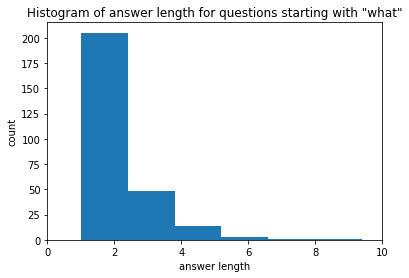

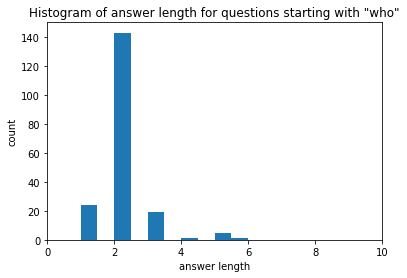

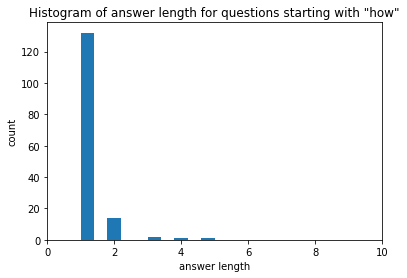

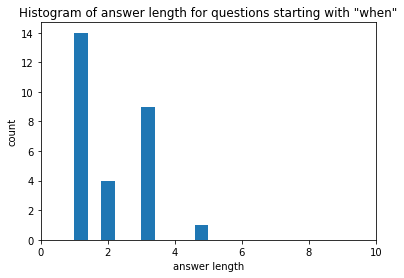

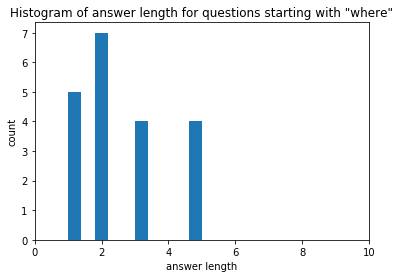

In [136]:
# Histogram of answer length given a list of ids.
def ids_histogram(ids, id_x_map, bins=None, **kwargs):
    plt.hist([id_x_map[id] for id in ids], bins)
    axis = plt.axes()
#     axis.set_xlim(0, bins)
    axis.set(
        xlim=(0, bins),
        xlabel='answer length',
        ylabel='count',
        **kwargs)
    plt.show()

ids_histogram(what_ids, id_ans_len_map, bins=10, title='Histogram of answer length for questions starting with "what"')
ids_histogram(who_ids, id_ans_len_map, bins=10, title='Histogram of answer length for questions starting with "who"')
ids_histogram(how_ids, id_ans_len_map, bins=10, title='Histogram of answer length for questions starting with "how"')
ids_histogram(when_ids, id_ans_len_map, bins=10, title='Histogram of answer length for questions starting with "when"')
ids_histogram(where_ids, id_ans_len_map, bins=10, title='Histogram of answer length for questions starting with "where"')

In [142]:
df = pd.DataFrame(data={
    'ground_truth': [1, 1, 1, 2, 2, 3],
    'pred': [2, 2, 6, 2, 2, 2],
}, )